In [ ]:
!pip3 install opendatasets
!pip3 install pandas

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

torch.manual_seed(1)

In [ ]:
import opendatasets as od
import pandas as pd

od.download(
    "https://www.kaggle.com/datasets/ubitquitin/geolocation-geoguessr-images-50k")

100%|█████████████████████████████████████████████████████████████████████| 6.66G/6.66G [02:04<00:00, 57.2MB/s]


In [ ]:
# {"username":"michaelhong2023","key":"5e9fe46d473686d8c0d2c485b4c6ba0b"}

In [ ]:
print(torch.cuda.is_available())

False


In [ ]:
import os 
root = os.getcwd() + '/geolocation-geoguessr-images-50k/compressed_dataset'
kaggleDict = {}
for subdir, dirs, files in os.walk(root):    
    for file in files:
        key, value = os.path.basename(subdir), file
        kaggleDict.setdefault(key, []).append(value)

In [ ]:
print(kaggleDict)

{'Bhutan': ['canvas_1629262074.jpg', 'canvas_1629527767.jpg', 'canvas_1629551780.jpg', 'canvas_1629992395.jpg', 'canvas_1629687800.jpg', 'canvas_1629840063.jpg', 'canvas_1629841778.jpg', 'canvas_1630279578.jpg', 'canvas_1629917248.jpg', 'canvas_1630076381.jpg', 'canvas_1630016900.jpg', 'canvas_1629590602.jpg', 'canvas_1630001705.jpg', 'canvas_1629867148.jpg', 'canvas_1629667140.jpg', 'canvas_1629701776.jpg', 'canvas_1629693073.jpg', 'canvas_1629700023.jpg', 'canvas_1630210758.jpg', 'canvas_1629900366.jpg'], 'Kenya': ['canvas_1629925277.jpg', 'canvas_1629837897.jpg', 'canvas_1630278825.jpg', 'canvas_1629433275.jpg', 'canvas_1630286494.jpg', 'canvas_1629420802.jpg', 'canvas_1629692576.jpg', 'canvas_1629738400.jpg', 'canvas_1629732477.jpg', 'canvas_1629956926.jpg', 'canvas_1629398720.jpg', 'canvas_1629279870.jpg', 'canvas_1629284902.jpg', 'canvas_1630075944.jpg', 'canvas_1629274559.jpg', 'canvas_1630023083.jpg', 'canvas_1630135568.jpg', 'canvas_1629503428.jpg', 'canvas_1629750753.jpg', 'c

In [ ]:
import random
random.seed(10)

for country in kaggleDict:
  if len(kaggleDict[country]) > 2000:
         print(country)
# Brazil, United States, United Kingdom, France and Japan have samples over 2000
brazilSet = kaggleDict['Brazil']
franceSet = kaggleDict['France']
ukSet = kaggleDict['United Kingdom']
japanSet = kaggleDict['Japan']
usSet = kaggleDict['United States']

Brazil
France
United Kingdom
United States
Japan


In [ ]:
for img in range(len(brazilSet)):
  brazilSet[img] = root+ '/Brazil/'+ brazilSet[img]
for img in range(len(franceSet)):
  franceSet[img] = root+ '/France/'+ franceSet[img]
for img in range(len(ukSet)):
  ukSet[img] = root+ '/United Kingdom/'+ ukSet[img]
for img in range(len(japanSet)):
  japanSet[img] = root+ '/Japan/'+ japanSet[img]
for img in range(len(usSet)):
  usSet[img] = root+ '/United States/'+ usSet[img]
  
brazilFiles = random.sample(brazilSet, 2000)
franceFiles = random.sample(franceSet, 2000)
ukFiles = random.sample(ukSet, 2000)
japanFiles = random.sample(japanSet, 2000)
usFiles = random.sample(usSet, 2000)

In [ ]:
import torch
import glob
from torch.utils.data import random_split

countries = ['Brazil','France','United Kingdom', 'Japan', 'United States']
num_class = len(countries)

img_files = brazilFiles+franceFiles+ukFiles+japanFiles+usFiles

# img_files = glob.glob(root+'/*/*.jpg',recursive=True)
print(len(img_files))
idx_to_class = {i:j for i, j in enumerate(countries)}
print(idx_to_class)
class_to_idx = {value:key for key,value in idx_to_class.items()}
print(class_to_idx)

#random split
train_idx,val_idx,test_idx=random_split(img_files, [0.6, 0.2, 0.2], generator=torch.Generator().manual_seed(42))
    
train_list=[img_files[i] for i in train_idx.indices]
test_list=[img_files[i] for i in test_idx.indices]
val_list=[img_files[i] for i in val_idx.indices]

print(len(train_idx.indices),len(test_idx.indices),len(val_idx.indices))
print(len(train_list),len(test_list),len(val_list))   
     

10000
{0: 'Brazil', 1: 'France', 2: 'United Kingdom', 3: 'Japan', 4: 'United States'}
{'Brazil': 0, 'France': 1, 'United Kingdom': 2, 'Japan': 3, 'United States': 4}
6000 2000 2000
6000 2000 2000


In [ ]:
import os
geoguessr_data = os.getcwd() + '/geoguessr_data'

if not os.path.isdir(geoguessr_data):
  os.makedirs(geoguessr_data)

train_path = geoguessr_data+'/train'
test_path = geoguessr_data+'/test'
valid_path = geoguessr_data+'/val'

if not os.path.isdir(train_path):
  os.makedirs(train_path)

if not os.path.isdir(test_path):
  os.makedirs(test_path)

if not os.path.isdir(valid_path):
  os.makedirs(valid_path)

In [ ]:
import shutil

train_path = geoguessr_data+'/train'
test_path = geoguessr_data+'/test'
valid_path = geoguessr_data+'/val'

for subdir, dirs, files in os.walk(root):
    for file in files:
        if 'Brazil' in subdir or 'France' in subdir or 'United Kingdom' in subdir or 'Japan' in subdir or 'United States' in subdir:
          for i in range(len(train_list)):
            if train_list[i] == os.path.join(subdir,file):
              if 'Brazil' in subdir:
                class_type = 'Brazil'
              elif 'France' in subdir:
                class_type = 'France'
              elif 'United Kingdom' in subdir:
                class_type = 'United Kingdom'
              elif 'Japan' in subdir:
                class_type = 'Japan'
              else:
                class_type='United States'

              path_name = os.path.join(train_path,class_type)

              if not os.path.exists(path_name):
                os.makedirs(path_name)
              shutil.copy(train_list[i], path_name)

          for i in range(len(test_list)):
            if test_list[i] == os.path.join(subdir,file):
              if 'Brazil' in subdir:
                class_type = 'Brazil'
              elif 'France' in subdir:
                class_type = 'France'
              elif 'United Kingdom' in subdir:
                class_type = 'United Kingdom'
              elif 'Japan' in subdir:
                class_type = 'Japan'
              else:
                class_type='United States'
              path_name = os.path.join(test_path,class_type)

              if not os.path.exists(path_name):
                os.makedirs(path_name)
              shutil.copy(test_list[i], path_name)

          for i in range(len(val_list)):
            if val_list[i] == os.path.join(subdir,file):
              if 'Brazil' in subdir:
                class_type = 'Brazil'
              elif 'France' in subdir:
                class_type = 'France'
              elif 'United Kingdom' in subdir:
                class_type = 'United Kingdom'
              elif 'Japan' in subdir:
                class_type = 'Japan'
              else:
                class_type='United States'
              path_name = os.path.join(valid_path,class_type)

              if not os.path.exists(path_name):
                os.makedirs(path_name)
              shutil.copy(val_list[i], path_name)

In [ ]:
import torchvision.datasets as datasets

transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=valid_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=27, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=27, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=27, shuffle=False)

# Get the class names from the dataset
class_names = train_dataset.classes

In [ ]:
print(class_names)

['Brazil', 'France', 'Japan', 'United Kingdom', 'United States']


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.name = "cnn"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 53 * 53, num_classes*2)
        self.fc2 = nn.Linear(num_classes*2, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x  

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, train_loader, val_loader, batch_size=27, learning_rate = 0.001, num_epochs=30):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy Loss and the optimizer will be Adam
    # These two were selected because:
    # Cross Entropy Loss - Penalizes the model more heavily when it makes larger errors, which is desirable for image classification
    # Adam - Converges faster than other optimization algorithms, which is important for large-scale image classification
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    ########################################################################
    # Set up some numpy arrays to store the training/test accuracy
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    print ("Training Started...")
    n = 0 # Iteration number
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_images = 0
        for imgs, labels in iter(train_loader):
            
            if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            # Forward pass, backward pass, and optimize
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            # Zero the parameter gradients
            optimizer.zero_grad()
            n += 1          
        
        # Get accuracy
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)

        print(("Epoch {}: Train acc: {} |" + "Validation acc: {}").format(epoch, train_acc[epoch], val_acc[epoch]))

        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
            
    epochs = np.arange(1, num_epochs + 1)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    return train_acc, val_acc, epochs

In [ ]:
def plot_curve(acc, epochs, curve_name):
  plt.plot(epochs, acc)
  plt.title(curve_name + " Curve (Default Parameters)")
  plt.xlabel("Epochs")
  plt.ylabel(curve_name + " Accuracy")
  plt.show()
  return

Training Started...
Epoch 0: Train acc: 0.2005 |Validation acc: 0.198
Epoch 1: Train acc: 0.2005 |Validation acc: 0.198
Epoch 2: Train acc: 0.2005 |Validation acc: 0.198
Epoch 3: Train acc: 0.2005 |Validation acc: 0.198
Epoch 4: Train acc: 0.20066666666666666 |Validation acc: 0.2
Epoch 5: Train acc: 0.20066666666666666 |Validation acc: 0.2
Epoch 6: Train acc: 0.2005 |Validation acc: 0.198
Epoch 7: Train acc: 0.20183333333333334 |Validation acc: 0.1955
Epoch 8: Train acc: 0.20066666666666666 |Validation acc: 0.2
Epoch 9: Train acc: 0.20183333333333334 |Validation acc: 0.1955
Epoch 10: Train acc: 0.20183333333333334 |Validation acc: 0.1955
Epoch 11: Train acc: 0.20183333333333334 |Validation acc: 0.1955
Epoch 12: Train acc: 0.20183333333333334 |Validation acc: 0.1955
Epoch 13: Train acc: 0.20183333333333334 |Validation acc: 0.1955
Epoch 14: Train acc: 0.20183333333333334 |Validation acc: 0.1955
Epoch 15: Train acc: 0.20183333333333334 |Validation acc: 0.1955
Epoch 16: Train acc: 0.201833

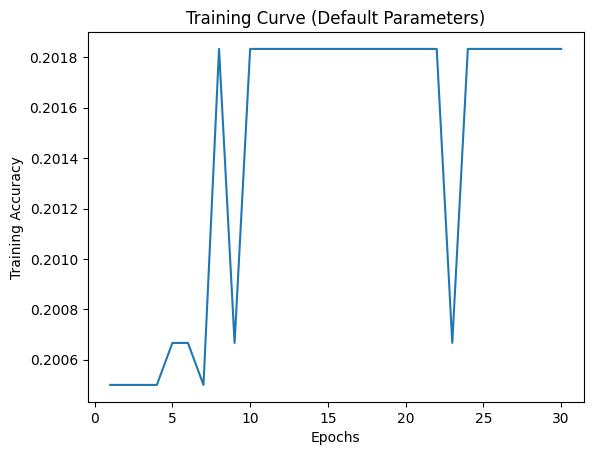

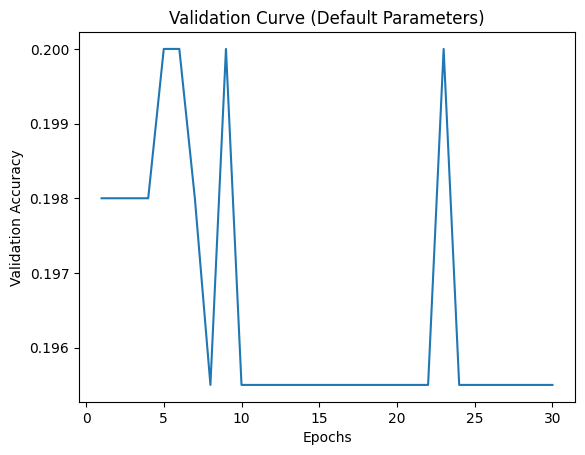

In [ ]:
model_default = CNN(5)
if torch.cuda.is_available():
    model_default.cuda()
train_acc_default, val_acc_default, epochs_default = train(model_default, train_loader, val_loader)
plot_curve(train_acc_default, epochs_default, "Training")
plot_curve(val_acc_default, epochs_default, "Validation")

Training Started...
Epoch 0: Train acc: 0.19983333333333334 |Validation acc: 0.1975
Epoch 1: Train acc: 0.2005 |Validation acc: 0.198
Epoch 2: Train acc: 0.20066666666666666 |Validation acc: 0.2
Epoch 3: Train acc: 0.20183333333333334 |Validation acc: 0.1955
Epoch 4: Train acc: 0.19716666666666666 |Validation acc: 0.209
Epoch 5: Train acc: 0.2005 |Validation acc: 0.198
Epoch 6: Train acc: 0.2005 |Validation acc: 0.198
Epoch 7: Train acc: 0.19983333333333334 |Validation acc: 0.1975
Epoch 8: Train acc: 0.20183333333333334 |Validation acc: 0.1955
Epoch 9: Train acc: 0.20183333333333334 |Validation acc: 0.1955
Epoch 10: Train acc: 0.19983333333333334 |Validation acc: 0.1975
Epoch 11: Train acc: 0.2005 |Validation acc: 0.198
Epoch 12: Train acc: 0.19716666666666666 |Validation acc: 0.209
Epoch 13: Train acc: 0.2005 |Validation acc: 0.198
Epoch 14: Train acc: 0.20066666666666666 |Validation acc: 0.2
Epoch 15: Train acc: 0.20183333333333334 |Validation acc: 0.1955
Epoch 16: Train acc: 0.20183

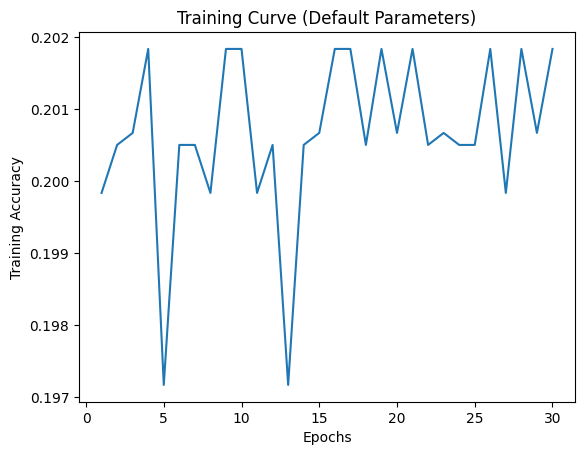

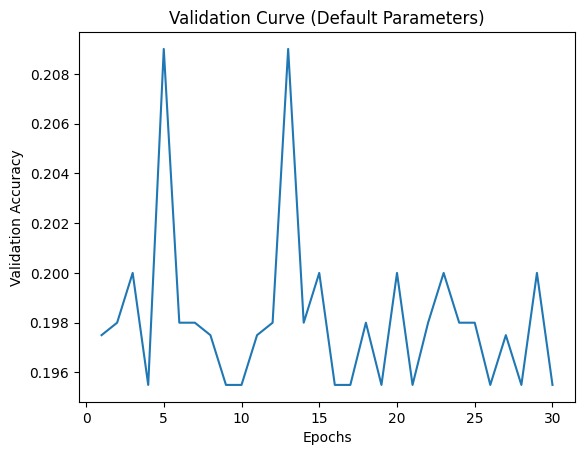

In [ ]:
model_higher_lr = CNN(5)
if torch.cuda.is_available():
    model_higher_lr.cuda()
train_acc_higher_lr, val_acc_higher_lr, epochs_higher_lr = train(model_higher_lr, train_loader, val_loader, learning_rate = 0.01)
plot_curve(train_acc_higher_lr, epochs_higher_lr, "Training")
plot_curve(val_acc_higher_lr, epochs_higher_lr, "Validation")

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.name = "cnn_model"
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 5)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

Training Started...
Epoch 0: Train acc: 0.292 |Validation acc: 0.2835
Epoch 1: Train acc: 0.3591666666666667 |Validation acc: 0.351
Epoch 2: Train acc: 0.4285 |Validation acc: 0.373
Epoch 3: Train acc: 0.54 |Validation acc: 0.416
Epoch 4: Train acc: 0.6296666666666667 |Validation acc: 0.4025
Epoch 5: Train acc: 0.7576666666666667 |Validation acc: 0.4025
Epoch 6: Train acc: 0.8665 |Validation acc: 0.379
Epoch 7: Train acc: 0.9025 |Validation acc: 0.3845
Epoch 8: Train acc: 0.9523333333333334 |Validation acc: 0.378
Epoch 9: Train acc: 0.9576666666666667 |Validation acc: 0.381
Epoch 10: Train acc: 0.965 |Validation acc: 0.3935
Epoch 11: Train acc: 0.956 |Validation acc: 0.3835
Epoch 12: Train acc: 0.9775 |Validation acc: 0.3845
Epoch 13: Train acc: 0.9766666666666667 |Validation acc: 0.377
Epoch 14: Train acc: 0.9788333333333333 |Validation acc: 0.384
Epoch 15: Train acc: 0.9805 |Validation acc: 0.3805
Epoch 16: Train acc: 0.9746666666666667 |Validation acc: 0.3695
Epoch 17: Train acc: 0.

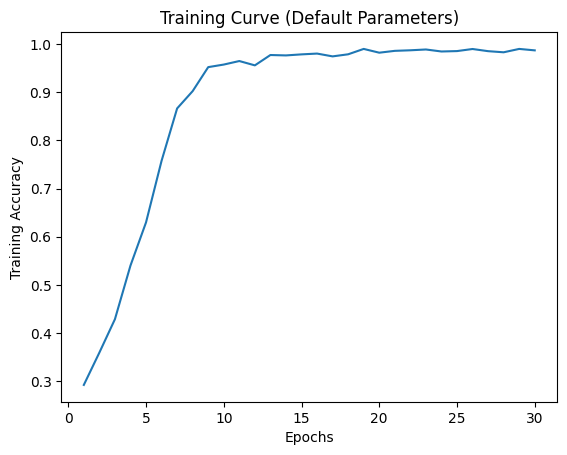

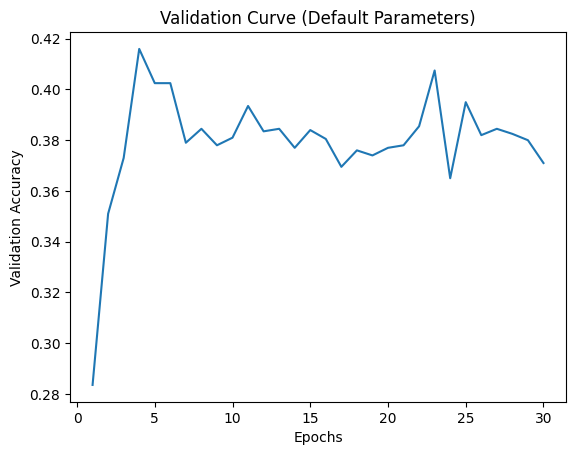

In [ ]:
model_diff = CNNModel()
if torch.cuda.is_available():
    model_diff.cuda()
train_acc_diff, val_acc_diff, epochs_diff = train(model_diff, train_loader, val_loader)
plot_curve(train_acc_diff, epochs_diff, "Training")
plot_curve(val_acc_diff, epochs_diff, "Validation")

In [ ]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.name = "mlp"
        self.fc1 = nn.Linear(3 * 224 * 224, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 5)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(-1, 3 * 224 * 224)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

Training Started...
Epoch 0: Train acc: 0.1955 |Validation acc: 0.2065
Epoch 1: Train acc: 0.19233333333333333 |Validation acc: 0.218
Epoch 2: Train acc: 0.20133333333333334 |Validation acc: 0.195
Epoch 3: Train acc: 0.19466666666666665 |Validation acc: 0.2025
Epoch 4: Train acc: 0.20466666666666666 |Validation acc: 0.1975
Epoch 5: Train acc: 0.2 |Validation acc: 0.1915
Epoch 6: Train acc: 0.20016666666666666 |Validation acc: 0.188
Epoch 7: Train acc: 0.19133333333333333 |Validation acc: 0.1985
Epoch 8: Train acc: 0.19583333333333333 |Validation acc: 0.1955
Epoch 9: Train acc: 0.21133333333333335 |Validation acc: 0.185
Epoch 10: Train acc: 0.20233333333333334 |Validation acc: 0.1885
Epoch 11: Train acc: 0.20316666666666666 |Validation acc: 0.195
Epoch 12: Train acc: 0.19983333333333334 |Validation acc: 0.2015
Epoch 13: Train acc: 0.1985 |Validation acc: 0.196
Epoch 14: Train acc: 0.20766666666666667 |Validation acc: 0.2105
Epoch 15: Train acc: 0.20116666666666666 |Validation acc: 0.208

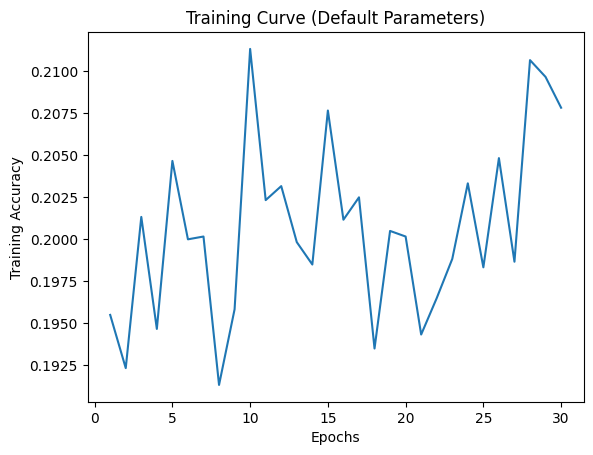

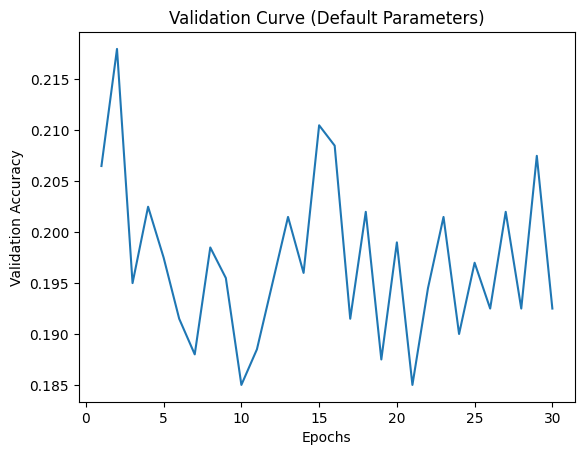

In [ ]:
model_mlp = MLPModel()
if torch.cuda.is_available():
    model_mlp.cuda()
train_acc_mlp, val_acc_mlp, epochs_mlp = train(model_mlp, train_loader, val_loader)
plot_curve(train_acc_mlp, epochs_mlp, "Training")
plot_curve(val_acc_mlp, epochs_mlp, "Validation")